(basic-plotting)=
# Plot results

A variety of plots can be generated using the `graphics` module. These include the following types:
- `plot_age_length_heatmap`: Plotting the age-length heatmap of abundance, biomass, etc.
- `plot_kriged_mesh`: Plotting the kriged mesh or survey data using several methods. 
- `plot_transect_map`: Plotting the survey transects and variables on a map.

`````{admonition} Plotting function keyword arguments
:class: tip
All plotting functions allow for `matplotlib.pyplot`-specific keyword arguments, such as for `imshow`, `scatter`, etc.
`````

In [ ]:
%run ./geostatistical.ipynb

## Import necessary modules

The module can be imported directly from `Echopop`.

In [8]:
from echopop import graphics as egra

A save directory can be optionally set that will generate the figures at the defined filepath. 

```python
SAVE_DIRECTORY = Path("C:/Data/Figures")
```

## Age-length heatmap

Distributions of abundance and biomass along length and age for each sex can be visualized via `plot_age_length_heatmap`. This expects the input table to be a multiindex table. This requires columns to be indexed by (`age_bin`, `sex`), and for rows to be indexed by `length_bin`. When examining the appropriate input `xarray.DataArray`, it should resemble the following:

In [10]:
from echopop.workflows.nwfsc_feat import apportionment

# Abundance 
dict_ds_kriged_abundance_table = apportionment.distribute_population_estimates(
    data=unextrapolated_results,
    proportions = dict_ds_number_proportion,
    variable = "abundance",
    group_columns = ["sex", "age_bin", "length_bin", "stratum_ks"],
    data_proportions_link={"geostratum_ks": "stratum_ks"}
)

# Biomass
dict_ds_kriged_biomass_table = apportionment.distribute_population_estimates(
    data=unextrapolated_results,
    proportions = dict_ds_weight_proportion,
    variable = "biomass",
    group_columns = ["sex", "age_bin", "length_bin", "stratum_ks"],
    data_proportions_link={"geostratum_ks": "stratum_ks"}
)

# Abundance
dict_ds_kriged_abundance_table["redistributed_unaged"] = apportionment.distribute_unaged_from_aged(
    population_table = dict_ds_kriged_abundance_table["unaged"],
    reference_table = dict_ds_kriged_abundance_table["aged"],
    collapse_dims = ["stratum_ks"],
    impute = False
)

# Biomass
dict_ds_kriged_biomass_table["redistributed_unaged"] = apportionment.distribute_unaged_from_aged(
    population_table = dict_ds_kriged_biomass_table["unaged"],
    reference_table = dict_ds_kriged_biomass_table["aged"],
    collapse_dims = ["stratum_ks"],
    impute=True,
    impute_variable=["age_bin"],
)

# Abundance
ds_kriged_abundance_table = apportionment.sum_population_tables(
    population_tables={
        "aged": dict_ds_kriged_abundance_table["aged"],
        "unaged": dict_ds_kriged_abundance_table["redistributed_unaged"]
    },
)

# Biomass
da_kriged_biomass_table = apportionment.sum_population_tables(
    population_tables={
        "aged": dict_ds_kriged_biomass_table["aged"],
        "unaged": dict_ds_kriged_biomass_table["redistributed_unaged"]
    },
)

In [11]:
from IPython.display import display

display(da_kriged_biomass_table)

<xarray.DataArray 'biomass' (length_bin: 40, sex: 2, age_bin: 22)> Size: 14kB
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[353.63810194,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [269.5325609 ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       ...,

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]], shape=(40, 2, 22))
Coordinates:
  * length_bin  (length_bin) category 680B (1.0, 3.0] ... (79.0, 81.0]
  * sex         (sex) object 16B 'female' 'male'
  * age_bin     (age_bin) category 374B (0.5, 1.5] (1.5, 2.5] ... (21.5, 22.5]

The `plot_age_length_heatmap` function has many arguments that can configure the table to one's preferences. 

- `data`: The input `xarrayDataArray` with the coordinates `"length_bin"` and `"age_bin"`.
- `include_filter`: Optional dictionary of filters to include specific data.
- `exclude_filter`: Optional dictionary of filters to exclude specific data.
- `replace_value`: Values excluded by `exclude_filter` can be optionally replaced with a set value (e.g. `0.0`) instead of being completely removed.
- `axis_kwargs`: Keyword arguments for axis formatting (e.g. labels) used by `matplotlib.pyplot`. 
- `plot_kwargs`: Keyword arguments used by `matplotliib.pyplot.subplots`.
- `colorbar_kwargs`: Keyword arguments for `matplotlib.pyplot.colorbar`.
- `imshow_kwargs`: Keyword arguments for `matplotlib.axes.Axes.imshow`.
- `save_path`: A `pathlib.Path` object defining the filepath for where the figure should be saved.
- `savefig_kwargs`: Keyword arguments for `matplotlib.pyplot.savefig`.

### Basic plotting

The most basic version of this plot can be generated via:

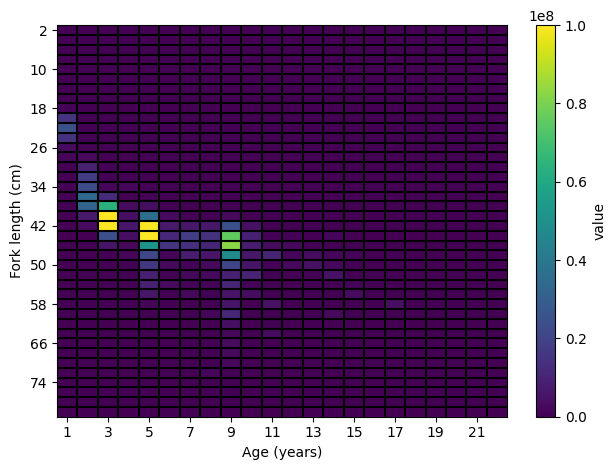

In [12]:
egra.plot_age_length_heatmap(data=da_kriged_biomass_table)

Here, *all* counts for each age-length cell have been summed, which means that this figure represents the combined male *and* female contributes to the kriged biomass estimates. Because we typically want descriptive labels, we can amend the figure using some of the `matplotlib.pyplot` keyword arguments:

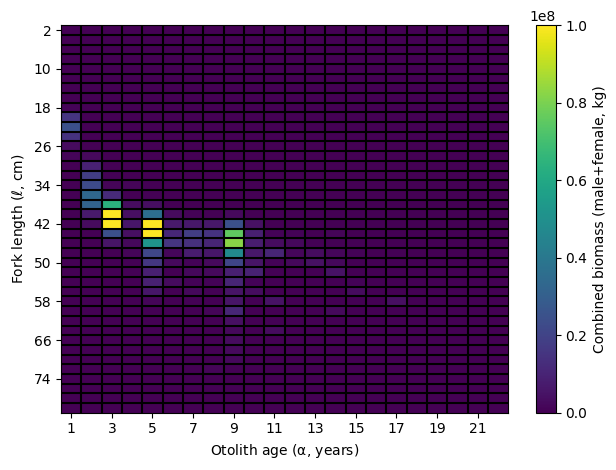

In [13]:
egra.plot_age_length_heatmap(
    data=da_kriged_biomass_table,
    colorbar_kwargs={"label": "Combined biomass (male+female, kg)"},
    axis_kwargs={"ylabel": r"Fork length ($\mathregular{\ell}$, cm)", 
                 "xlabel": r"Otolith age ($\mathregular{\alpha}$, years)"},
)

To save the figure, we can then add the `savepath` and optional `savefig_kwargs`:

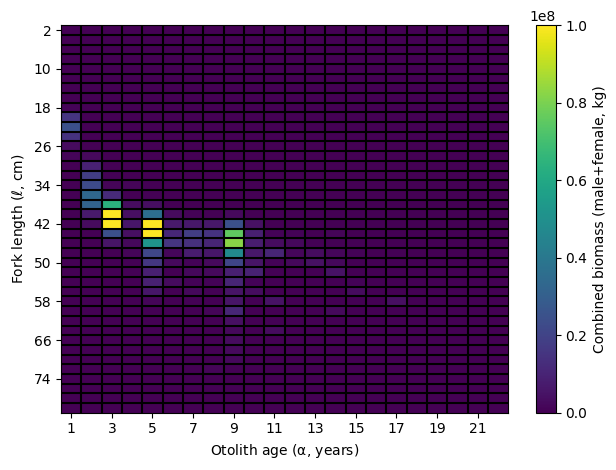

In [ ]:
egra.plot_age_length_heatmap(
    data=da_kriged_biomass_table,
    colorbar_kwargs={"label": "Combined biomass (male+female, kg)"},
    axis_kwargs={"ylabel": r"Fork length ($\mathregular{\ell}$, cm)", 
                 "xlabel": r"Otolith age ($\mathregular{\alpha}$, years)"},
    savepath=SAVE_DIRECTORY / "kriged_biomass_age_length_heatmap_plus.png",
    savefig_kwargs={"dpi": 300},
)

### Filtering by age and sex

The age-length heatmap can be refined for specific sexes, lengths, and ages by using the `include_filter`, `exclude_filter`, and `replace_value` arguments. For instance, the male-only figure can be generated via:

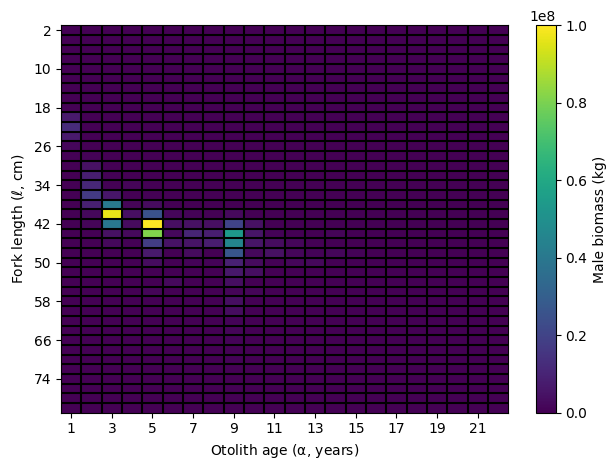

In [16]:
egra.plot_age_length_heatmap(
    data=da_kriged_biomass_table,
    include_filter={"sex": "male"},
    colorbar_kwargs={"label": "Male biomass (kg)"},
    axis_kwargs={"ylabel": r"Fork length ($\mathregular{\ell}$, cm)", 
                 "xlabel": r"Otolith age ($\mathregular{\alpha}$, years)"},
)

For this dataset, `include_filter("sex": "male")` would be equivalent to `exclude_filter("sex": "female")` since only male and female fish contribute to this particular table (**note**: this may not always be the case). Similarly, specific ages can be excised from the dataset: 

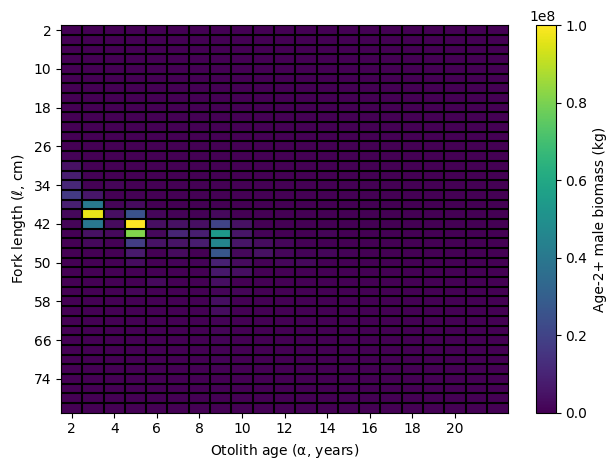

In [17]:
egra.plot_age_length_heatmap(
    data=da_kriged_biomass_table,
    include_filter={"sex": "male"},
    exclude_filter={"age_bin": [0, 1]},
    colorbar_kwargs={"label": "Age-2+ male biomass (kg)"},
    axis_kwargs={"ylabel": r"Fork length ($\mathregular{\ell}$, cm)", 
                 "xlabel": r"Otolith age ($\mathregular{\alpha}$, years)"},
)

Here, all age columns less than 2 years have been completely removed. Alternatively, we may want to retain that column but simply set it to `0.0`:

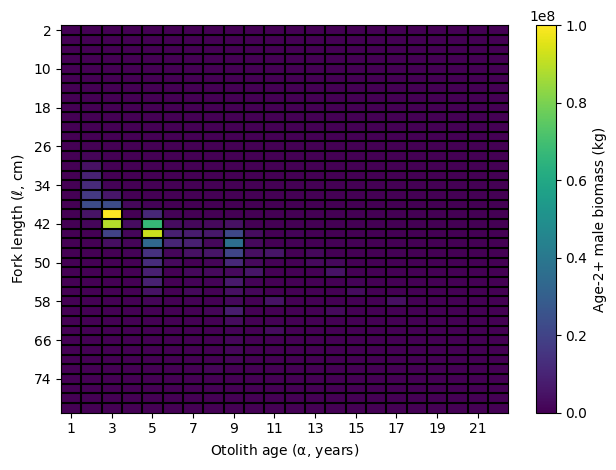

In [18]:
egra.plot_age_length_heatmap(
    data=da_kriged_biomass_table,
    include_filter={"sex": "male"},
    exclude_filter={"age_bin": [0, 1]},
    replace_value=0.0,
    colorbar_kwargs={"label": "Age-2+ male biomass (kg)"},
    axis_kwargs={"ylabel": r"Fork length ($\mathregular{\ell}$, cm)", 
                 "xlabel": r"Otolith age ($\mathregular{\alpha}$, years)"},
)

### Adjusting the aesthetics

The skew of these distributions can obscure the colormap. Both `colorbar_kwargs` and `imshow_kwargs` can be adjusted to help "even" out or adjust the aesthetics of the plot to make the smaller values more prominent and separated from the background values of `0.0`. First, we can create an entirely new scaled colormap using log scaling:

In [20]:
from matplotlib.colors import SymLogNorm
import matplotlib.pyplot as plt

# Define scale 
norm = SymLogNorm(linthresh=1., vmin=0., vmax=da_kriged_biomass_table.max().max())

# Create colormap
scaled_colormap = plt.cm.ScalarMappable(norm=norm, cmap="magma")

We can then add the normalized values and corresponding scaled colormap to the plot:

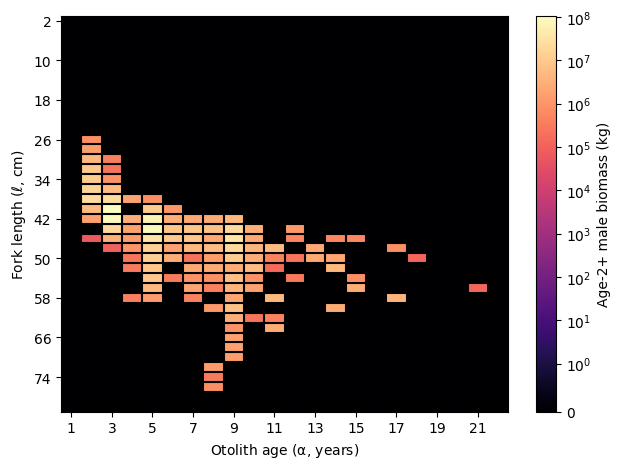

In [21]:
egra.plot_age_length_heatmap(
    data=da_kriged_biomass_table,
    include_filter={"sex": "male"},
    exclude_filter={"age_bin": [0, 1]},
    replace_value=0.0,
    colorbar_kwargs={"mappable": scaled_colormap, "label": "Age-2+ male biomass (kg)"},
    imshow_kwargs={"norm": norm, "cmap": "magma"},
    axis_kwargs={"ylabel": r"Fork length ($\mathregular{\ell}$, cm)", 
                 "xlabel": r"Otolith age ($\mathregular{\alpha}$, years)"},
)

## Transect map

Spatial distributions of different along-transect variables can be visualized via `plot_transect_map`. This expects a `pandas.DataFrame` or `geopandas.GeoDataFrame` comprising appropriate coordinates (e.g. `longitude`, `latitude`). The `plot_transect_map` function has many arguments that can configure the table to one's preferences. 

- `data`: The input `pandas.DataFrame` or `geopandas.GeoDataFrame` with coordinates and desired variable for plotting.
- `variable`: The name of the column within the `DataFrame`/`GeoDataFrame` to plot. 
- `projection`: The CRS (e.g. `"epsg:4326"`) that should either be a projected or geodetic coordinate system copmatible with the `geopandas.GeoDataFrame`-class.
- `coordinate_names`: This is a tuple comprising the coordinate names (i.e. columns within the `DataFrame`/`GeoDataFrame`) with an expected order of 'horizontal' followed by 'vertical'. For instance, this may look like `("longitude", "latitude")` or `("x", "y")`.
- `scatter_kwargs`: Keyword arguments for `matplotlib.axes.Axes.scatter`. 
- `transect_kwargs`: Additional keyword arguments passed to `geopandas.GeoDataFrame.plot` for the transect lines. 
- `coast_kwargs`: Keyword arguments for `cartopy.feature.NaturalEarthFeature` used for coastline plotting.
- `axis_kwargs`: Keyword arguments for axis formatting (e.g. labels) used by `matplotlib.pyplot`. 
- `plot_kwargs`: Keyword arguments used by `matplotliib.pyplot.subplots`.
- `colorbar_kwargs`: Keyword arguments for `matplotlib.pyplot.colorbar`.
- `save_path`: A `pathlib.Path` object defining the filepath for where the figure should be saved.
- `savefig_kwargs`: Keyword arguments for `matplotlib.pyplot.savefig`.

### Basic plotting

The most basic version of this plot can be generated via:

C:\Users\Brandyn\GitHub\echopop\echopop\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(
C:\Users\Brandyn\GitHub\echopop\echopop\graphics\transect_map.py:224: UserWarning: The following keys were not accepted by 'axes' and were pruned: ['extent']
  ax = gutils.call_with_pruned(plt.axes, {"extent": [x0, x1, y0, y1], **axis_kwargs})


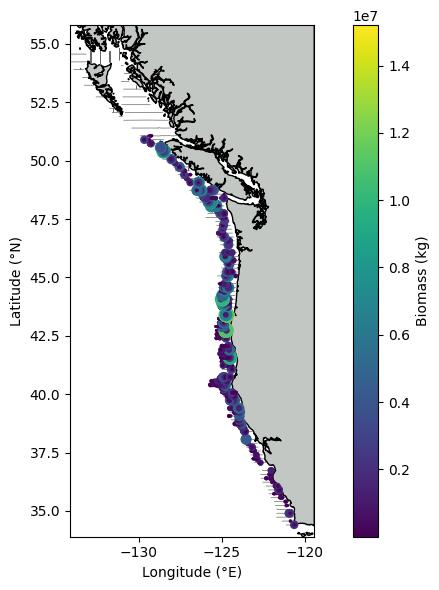

In [ ]:
egra.plot_transect_map(
    data=df_nasc_all_ages,
    variable="biomass",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
    savepath=SAVE_DIRECTORY / "transect_map_base.png",
    plot_kwargs={"figsize": (8, 6)},
    savefig_kwargs={"dpi": 300}
)

### Modifying the scatter points

We can pass a few keyword arguments to modify the behavior of the scatterplot points, such as the color and transparency:

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(
C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\transect_map.py:226: UserWarning: The following keys were not accepted by 'axes' and were pruned: ['extent']
  ax = gutils.call_with_pruned(plt.axes, {"extent": [x0, x1, y0, y1], **axis_kwargs})


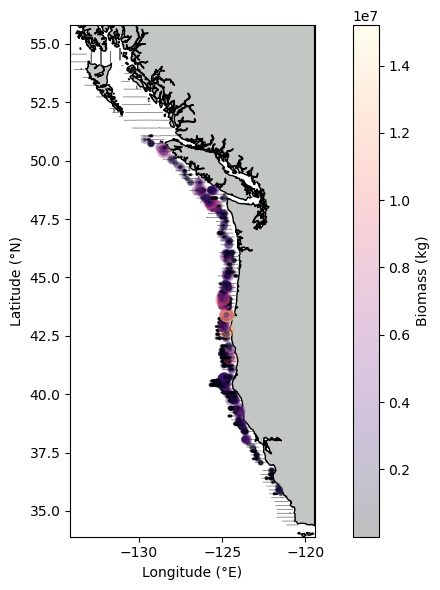

In [ ]:
egra.plot_transect_map(
    data=df_nasc_all_ages,
    variable="biomass",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)", "cmap": "magma"},
    scatter_kwargs={"alpha": 0.25, "cmap": "magma"},
    plot_kwargs={"figsize": (8, 6)},
)

### Modifying the coast and transect lines

We can also modify the behavior of the coastline and transect lines:

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(
C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\transect_map.py:226: UserWarning: The following keys were not accepted by 'axes' and were pruned: ['extent']
  ax = gutils.call_with_pruned(plt.axes, {"extent": [x0, x1, y0, y1], **axis_kwargs})


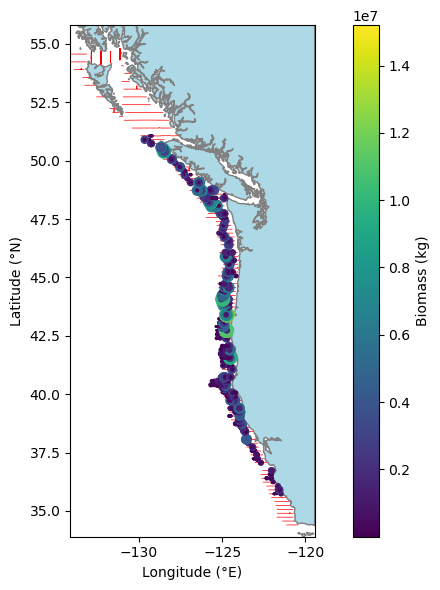

In [ ]:
egra.plot_transect_map(
    data=df_nasc_all_ages,
    variable="biomass",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
    coast_kwargs={"edgecolor": "gray", "facecolor": "lightblue"},
    transect_kwargs={"color": "red"},
    plot_kwargs={"figsize": (8, 6)},
)

## Kriged mesh results

Spatial distributions of kriged variables can be visualized via `plot_kriged_mesh`. This expects a `pandas.DataFrame` or `geopandas.GeoDataFrame` comprising appropriate coordinates (e.g. `longitude`, `latitude`). The `plot_kriged_mesh` function has many arguments that can configure the table to one's preferences. 

- `data`: The input `pandas.DataFrame` or `geopandas.GeoDataFrame` with coordinates and desired variable for plotting.
- `variable`: The name of the column within the `DataFrame`/`GeoDataFrame` to plot. 
- `projection`: The CRS (e.g. `"epsg:4326"`) that should either be a projected or geodetic coordinate system copmatible with the `geopandas.GeoDataFrame`-class.
- `coordinate_names`: This is a tuple comprising the coordinate names (i.e. columns within the `DataFrame`/`GeoDataFrame`) with an expected order of 'horizontal' followed by 'vertical'. For instance, this may look like `("longitude", "latitude")` or `("x", "y")`.
- `plot_type`: Type of plot to produce. Options are:
    - `"hexbin"`: Creates a hexagonal binned plot using `matplotlib.pyplot.hexbin`, which visualizes a summary statistic defined by the user (via the `reduce_C_function` argument, which defaults to `numpy.mean`) over a two-dimensional grid of hexagons. The plotted hexagonal bins can be configured using keyword arguments supplied to the `hexbin_kwargs` argument.
    - `"pcolormesh"`: Interpolates the variable onto a regular grid using `interpolation_mesh`, which internally leverages the `verde` library for spatial ineroplation that returns an `xarray.DataArray` object. The resulting grid is then displayed as a pseudcolor mesh using `xarray.DataArray.plot.pcolormesh`. The plotted pseudocolor mesh can be configured using keyword arguments supplied to the `pseudocolormesh_kwargs` argument.
    - `"scatter"`: Plots each data point individually using `matplotlib.axes.Axes.scatter` color poitns based on the variabel value. The plotted points can be configured using keyword
    arguments supplied to the `scatter_kwargs` argument.
- `scatter_kwargs`: Keyword arguments for `matplotlib.axes.Axes.scatter`. 
- `hexbin_kwargs`: Keyword arguments for `matplotlib.pyplot.hexbin`.
- `pseudocolormesh_kwargs`: Keyword arguments for `xarray.DataArray.plot.pcolormesh`.
- `coast_kwargs`: Keyword arguments for `cartopy.feature.NaturalEarthFeature` used for coastline plotting.
- `axis_kwargs`: Keyword arguments for axis formatting (e.g. labels) used by `matplotlib.pyplot`. 
- `plot_kwargs`: Keyword arguments used by `matplotliib.pyplot.subplots`.
- `colorbar_kwargs`: Keyword arguments for `matplotlib.pyplot.colorbar`.
- `save_path`: A `pathlib.Path` object defining the filepath for where the figure should be saved.
- `savefig_kwargs`: Keyword arguments for `matplotlib.pyplot.savefig`.

### Basic plotting

The most basic version of this plot can be generated via:

C:\Users\Brandyn\GitHub\echopop\echopop\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


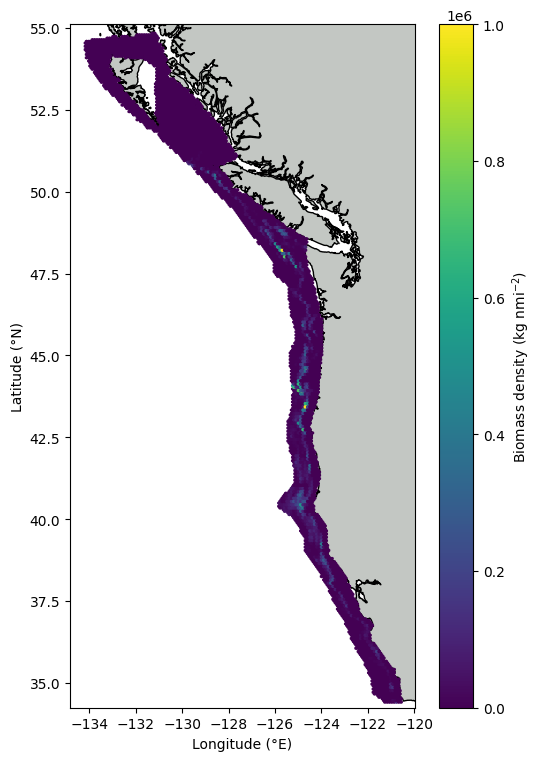

In [16]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass_density",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": r"Biomass density (kg $\mathregular{nmi^{-2}}$)"},
    savepath=SAVE_DIRECTORY / "kriged_mesh_hexbin_base.png"
)

Like earlier, we can adjust the `vmin` and `vmax` scaling, along with other colorbar-specific arguments, to help visualize the variability in our interpolated field:

C:\Users\Brandyn\GitHub\echopop\echopop\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


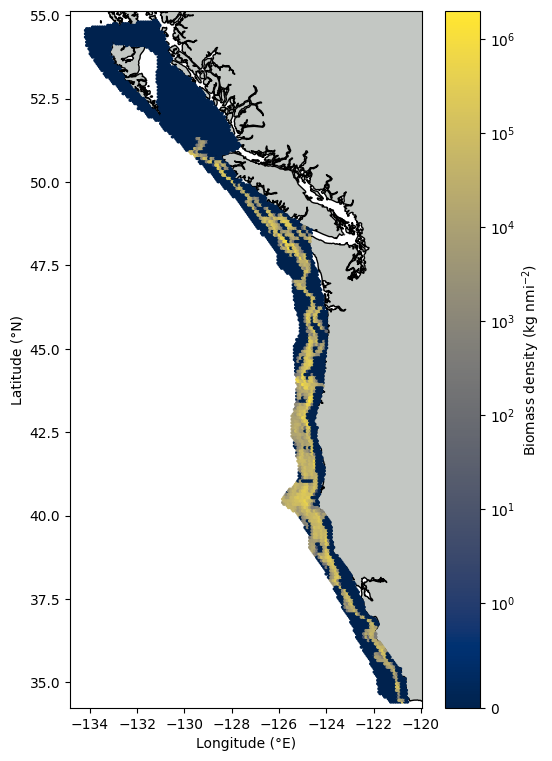

In [17]:
# Define scale 
norm = SymLogNorm(linthresh=1., vmin=0., vmax=unextrapolated_results.biomass_density.max())

# Create colormap
scaled_colormap = plt.cm.ScalarMappable(norm=norm, cmap="cividis")

# Plot
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass_density",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": r"Biomass density (kg $\mathregular{nmi^{-2}}$)",
                     "mappable": scaled_colormap},
    hexbin_kwargs={"norm": norm, "cmap": "cividis"},
    savepath=SAVE_DIRECTORY / "kriged_mesh_hexbin_base.png"
)


    

The default `plot_type` is `hexbin`, which here shows the mean biomass density for each hexagonal bin.

### Adjusting the hexagonal binning

The hexagonal bins can be adjusted in several ways. For instance, one can select a new grid size for the hexagons to be computed over:

C:\Users\Brandyn\GitHub\echopop\echopop\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


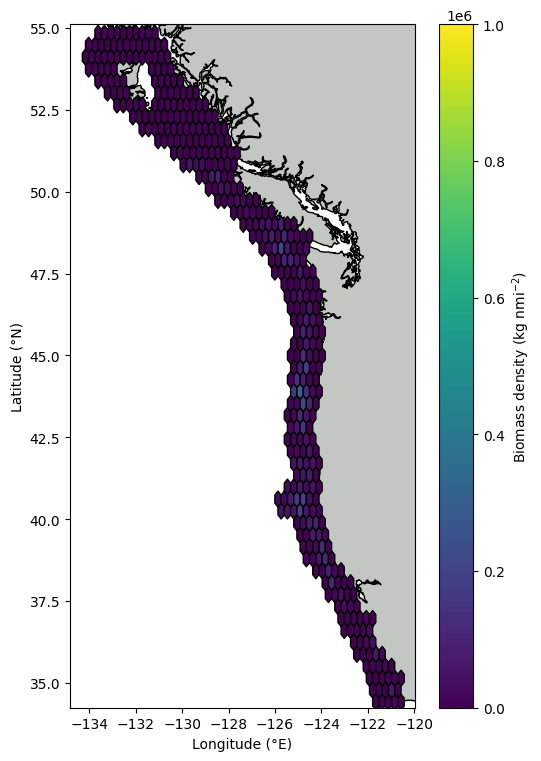

In [24]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass_density",
    hexbin_kwargs={"gridsize": 50, "edgecolors": "black"},
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": r"Biomass density (kg $\mathregular{nmi^{-2}}$)"},
)

Alternatively, the metrics other than the mean can be supplied, such as the maximum value in each hexagon:

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


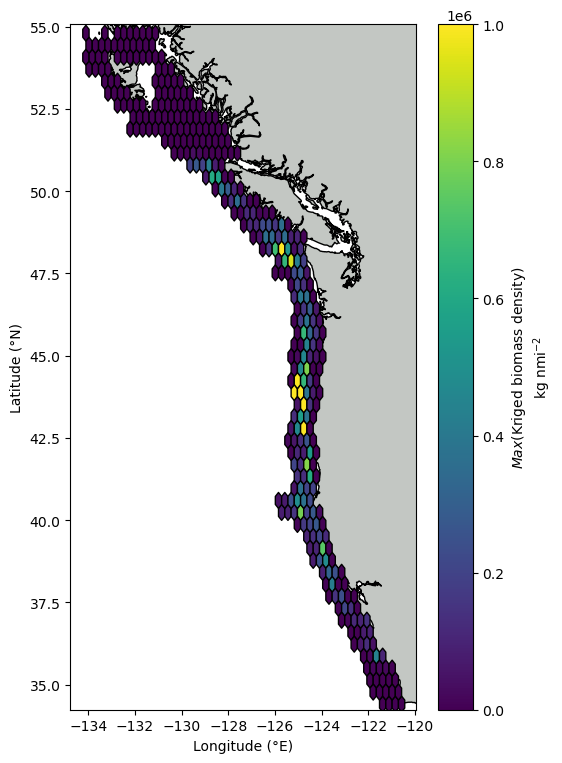

In [ ]:
import numpy as np

egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass_density",
    hexbin_kwargs={"gridsize": 50, "edgecolors": "black", "reduce_C_function": np.max},
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "$Max$(Kriged biomass density)\nkg nmi$^{-2}$"},
)

### Scatter plot.

Using `plot_type = "scatter"` produces "simplest" plot that will likely render quicker than the other two types for smaller datasets:

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


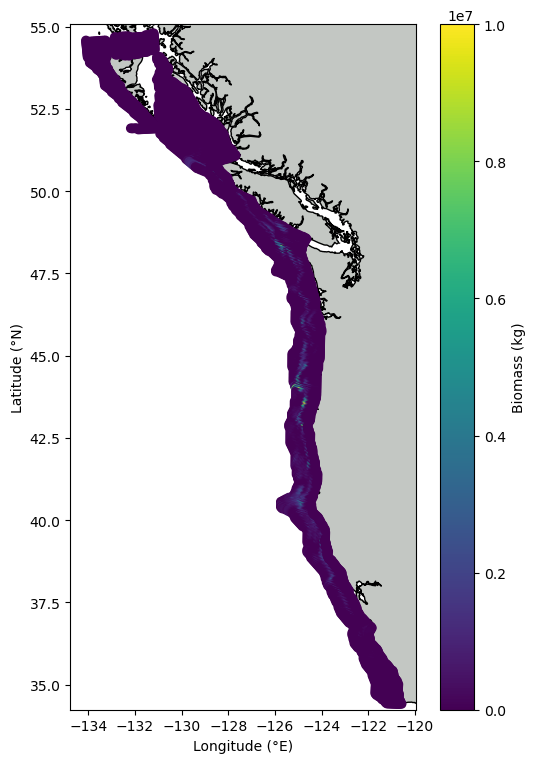

In [ ]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass",
    plot_type="scatter",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
)

This will accept similar keyword arguments as those described for the `plot_age_length_heatmap` function above.

### Adjusting the pseudocolor mesh

Alternatively, these data can be interpolated to generate a pseudocolor plot via a nearest-neighbors algorithm. This can be helpful for visualizing broader spatial trends where data may be sparse or otherwise noisy:

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


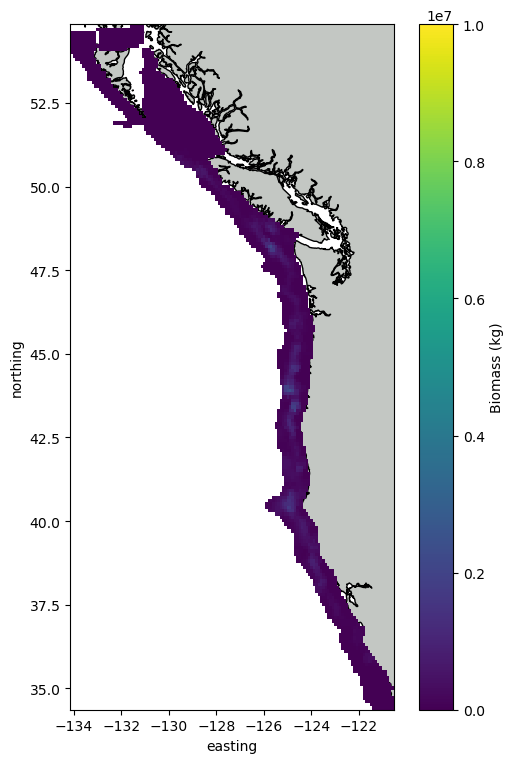

In [ ]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass",
    plot_type="pcolormesh",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
)

The spatial extent of the interpolation can be adjusted via `pseudocolormesh_kwargs` where the keyword argument `"spacing"` is in degrees. So for instance, `"spacing": 0.01` means that the interpolator smooths values over a 0.01 degree increment in all directions around each point: 

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


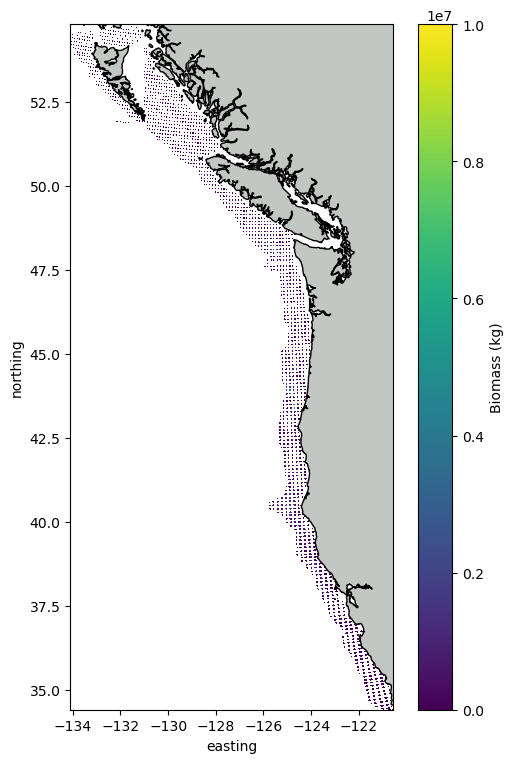

In [ ]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass",
    plot_type="pcolormesh",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
    pseudocolormesh_kwargs={"spacing": 0.01}
)

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


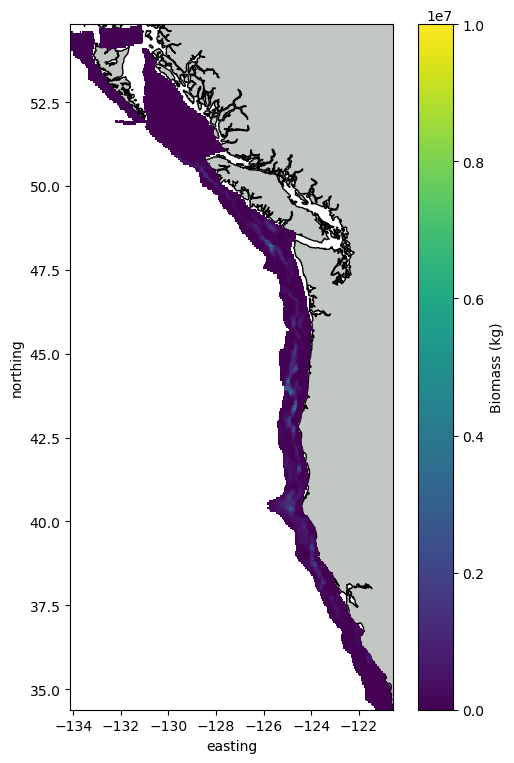

In [ ]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass",
    plot_type="pcolormesh",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
    pseudocolormesh_kwargs={"spacing": 0.05}
)

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


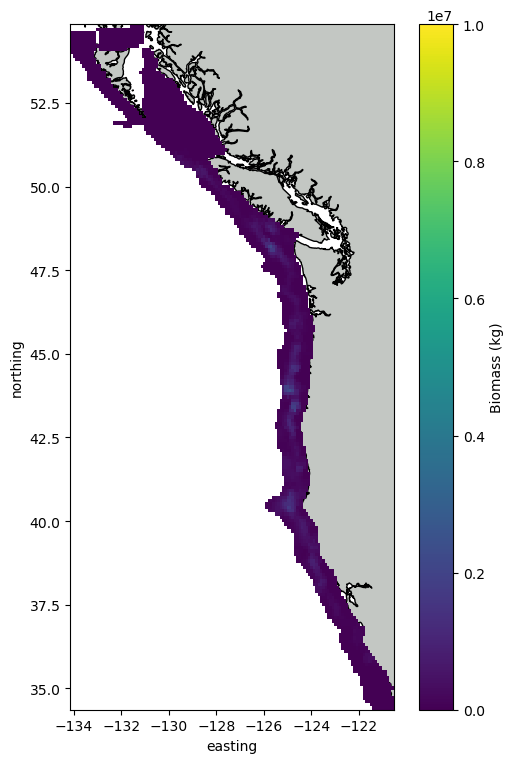

In [ ]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass",
    plot_type="pcolormesh",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
    pseudocolormesh_kwargs={"spacing": 0.1}
)

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\graphics\utils.py:118: UserWarning: The following keys were not accepted by 'NaturalEarthFeature' and were pruned: ['edgecolor', 'facecolor']
  coast_feature = call_with_pruned(


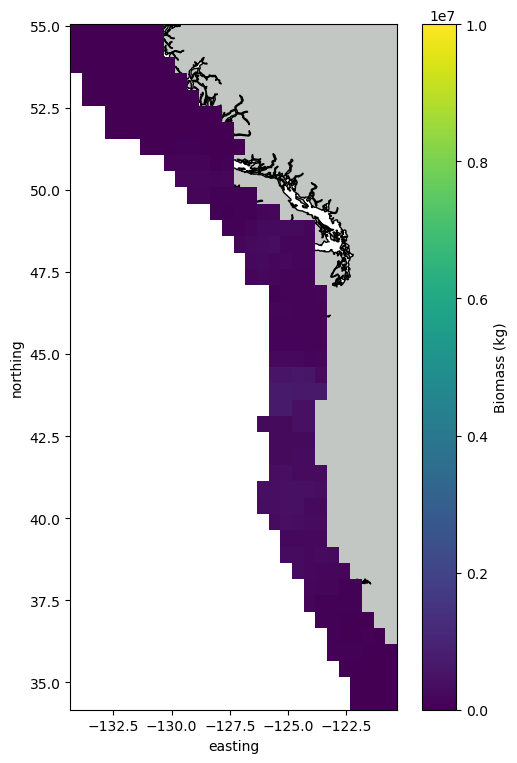

In [ ]:
egra.plot_kriged_mesh(
    data=unextrapolated_results,
    variable="biomass",
    plot_type="pcolormesh",
    axis_kwargs={"xlabel": "Longitude (\u00b0E)", "ylabel": "Latitude (\u00b0N)"},
    colorbar_kwargs={"label": "Biomass (kg)"},
    pseudocolormesh_kwargs={"spacing": 0.5}
)